# 5.3. Optimización de carteras I

- Descarga los datos del último año de algunos activos usando IEX. Denominamos $n$ como el número de activos elegidos.
- Crea un dataframe solo con los datos de cierre, tendrá dimensiones $m \times n$ con $m$ el número de días y $n$ en número de activos.
- Calcula un portfolio aleatorio:
   - Genera uno vector de pesos $\mathbf{w}$ aleatorios de dimensiones $n \times 1$, donde $n$ es el número de activos. Los pesos tienen que cumplir que  $w_i \ge 0, \; i = 1,\dots, n$ y $\sum_{i=1}^{n} w_i = 1$ dado que solo permitimos estar en largo.
   - Calcula el retorno y la desviacion típica del portfolio:
       - $R_p = \mathbf{w^T \mu}$ donde $\mathbf{\mu}$ es un vector con la media de los retornos diarios de los activos, con dimensiones $n \times 1$.
       - $\sigma_p = \sqrt{\mathbf{w}^T\Sigma \mathbf{w}}$, donde $\Sigma$ es la matriz de covarianzas de los retornos, con dimensiones $n \times n$
- Realiza una simulación de montecarlo para ello:
   - Repite el procceso anterior $k$ veces por ejemplo 10000, guardando los pesos $\mathbf{w}$, $R_p$ y $\sigma_p$ de cada experimento.
   - Realiza una figura con todos los puntos.
   - Selecciona el punto de máximo ratio sharpe:
     - Calcula el ratio sharpe para cada uno de los porfolios generados. El ratio sharpe se calcula como:
     \begin{equation*}
     S_p = \frac{R_p - R_f}{\sigma_p}
     \end{equation*}
     asumimos que $R_f$, el retorno del activo sin riesgo, es 0. 
     - Obtén el porfolio con el $S_p$ mayor.
     - Pinta este punto en la figura y obtén los pesos.
      
<center>
<img src="imgs/harry.jpeg"  alt="drawing" width="300"/>
<br />    Harry Markowitz, Novel 1990
</center>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import urllib.request
import pandas as pd

### Descarga de datos

In [5]:
import utils

In [6]:
sym = ['AAPL', 'FB', 'JPM', 'BRK.B', 'GOOG']
st_range = '5y'
dict_data = {}
for tck in sym:
    dict_data[tck] = utils.get_data_iex(tck, st_range=st_range).close

In [7]:
data_close = pd.DataFrame(dict_data)

### Random porfolio

In [8]:
returns = np.log(data_close).diff().dropna()

cov_returns = returns.cov()
mean_returns = returns.mean()
    
list_r_p = []
list_std_p = []
list_w = []
for _ in range(10000):
    w = np.random.rand(5)
    w = w / np.sum(w)
    r_p = mean_returns.dot(w)
    std_p = np.sqrt(w @ cov_returns.values @ w)  
    list_r_p.append(r_p)
    list_std_p.append(std_p)
    list_w.append(w)

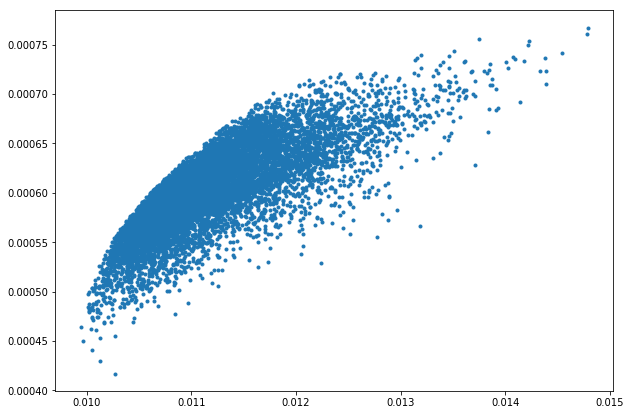

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(list_std_p, list_r_p, '.')

#### Max sharpe ratio portfolio

In [10]:
arr_std_p = np.array(list_std_p)
arr_r_p = np.array(list_r_p)
s_r = arr_r_p/arr_std_p
idx_m_sr = np.argmax(s_r)

In [11]:
r_m_sr = arr_r_p[idx_m_sr]
std_m_sr = arr_std_p[idx_m_sr]
w_m_sr = list_w[idx_m_sr]

In [12]:
pd.Series(w_m_sr, index=cov_returns.columns)

AAPL     0.120483
FB       0.329847
JPM      0.485239
BRK.B    0.000787
GOOG     0.063644
dtype: float64

#### Plot max sharpe ratio portfolio

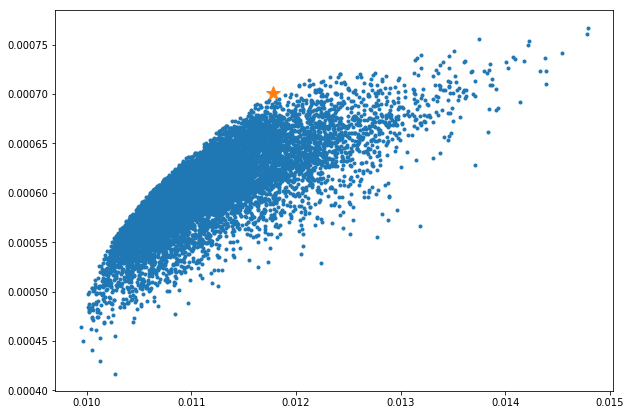

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(list_std_p, list_r_p, '.')
ax.plot(std_m_sr, r_m_sr, '*', markersize=15)
#ax.set_xlim(left=0)
#ax.set_ylim(0)

## Math opt con cvxpy

El problema de la frontera eficiente se puede tratar como un problema de optimización cuadrática.

La frontera eficiente se puede encontrar solucionando el siguiente problema:

\begin{equation*}
\begin{aligned}
& \underset{}{\text{maximize}}
& &  \mathbf{w^T \mu} - \gamma \mathbf{w}^T\Sigma \mathbf{w}\\
& \text{subject to}
& & w_i \ge 0, \; i = 1,\dots, n \\
&&& \sum_{i=1}^{n} w_i = 1
\end{aligned}
\end{equation*}
Donde $\mathbf{w}$ es el vector de pesos a optimizar, $\mathbf{w^T \mu}$ es el retorno del portfolio, $\mathbf{w}^T\Sigma \mathbf{w}$ es la varianza del portfolio y $\gamma$ es un parámetro de adversión al riesgo.

Variando $\gamma$ obtenemos los diferentes puntos de la frontera. Si $\gamma=0$ maximizamos solo el retono y si  $\gamma \rightarrow \infty$ obtenemos el portfolio de mínimo riesgo. Variando  $\gamma$  obtenemos el *risk-return trade-off* óptimo.

Puedes encontrar más información en: https://en.wikipedia.org/wiki/Modern_portfolio_theory

Para ejecutar el siguiente código necesitas installar cvxpy: ```pip install cvxpy```

In [14]:
import cvxpy as cp

In [15]:
def optimal_portfolio(returns, n_samples=1000, gamma_low=-1, gamma_high=10):
    sigma = returns.cov().values
    mu = np.mean(returns, axis=0).values  
    n = sigma.shape[0]        
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T*w
    risk = cp.quad_form(w, sigma)
    
    prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
                      [cp.sum(w) == 1,  w >= 0]) 
    # Equivalente 
    #prob = cp.Problem(cp.Minimize(risk - gamma*ret), 
    #                  [cp.sum(w) == 1,  w >= 0])   
    risk_data = np.zeros(n_samples)
    ret_data = np.zeros(n_samples)
    gamma_vals = np.logspace(gamma_low, gamma_high, num=n_samples)
    
    portfolio_weights = []    
    for i in range(n_samples):
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[i] = np.sqrt(risk.value)
        ret_data[i] = ret.value
        portfolio_weights.append(w.value)   
    return ret_data, risk_data, gamma_vals, portfolio_weights

In [16]:
ret_data, risk_data, gamma_vals, portfolio_weights = optimal_portfolio(returns)

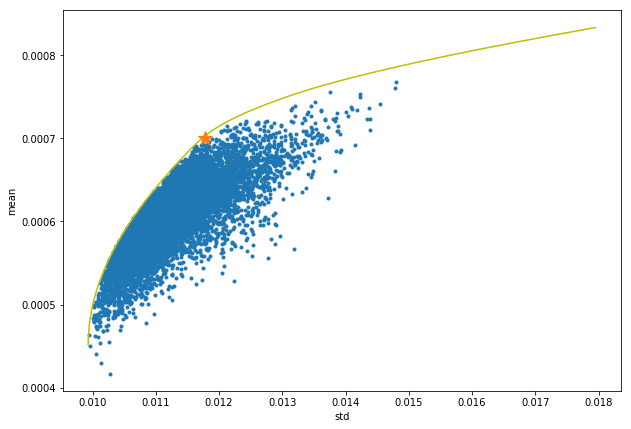

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(list_std_p, list_r_p, '.')
ax.plot(risk_data, ret_data, 'y')
ax.plot(std_m_sr, r_m_sr, '*', markersize=15)
_ = ax.set_xlabel('std')
_ = ax.set_ylabel('mean')